In [1]:
import torchaudio
import torch
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import sys
from torch.autograd import Variable
import math
# from torchsummary import summary
from torchinfo import summary

import os
import soundfile as sf
from os import listdir
from os.path import isdir, join
import pandas as pd
import pathlib
import torch.optim as optim
import tensorflow as tf

from tqdm.notebook import tqdm

C:\Users\cferr\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\cferr\anaconda3\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading in the data

In [17]:
data_dir='C:/Users/cferr/Documents/4th Year/FYP Data/speech_commands_v0.02'
data_dir_mini='C:/Users/cferr/OneDrive/Documents/4th Year/FYP/Implementation/data/mini_speech_commands/'
keywords = [name for name in listdir(data_dir) if isdir(join(data_dir, name))]
#remove bg noise as it not a keyword
keywords.remove('_background_noise_')
print(keywords)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [18]:
word2index = {
    # core words
    "backward": 0,
    "bed": 1,
    "bird": 2,
    "cat": 3,
    "dog": 4,
    "down": 5,
    "eight": 6,
    "five": 7,
    "follow": 8,
    "forward": 9,
    "four": 10,
    "go": 11,
    "happy": 12,
    "house": 13,
    "learn": 14,
    "left": 15,
    "marvin": 16,
    "nine": 17,
    "no": 18,
    "off": 19,
    "on":20,
    "one":21,
    "right":22,
    "seven":23,
    "sheila":24,
    "six":25,
    "stop":26,
    "three":27,
    "tree":28,
    "two":29,
    "up":30,
    "visual":31,
    "wow":32,
    "yes":33,
    "zero":34
}

index2word = [word for word in word2index]

In [19]:
filenames = []
y = []
for word_class in word2index:
    for files in listdir(join(data_dir, word_class)):
        filenames.append(join(word_class, files))
        y.append(word2index[word_class]) 

In [20]:
#create a dictionary of the filenames and labels
combined_dict = dict(zip(filenames,y))
#save that dictionary
np.save('files_dict', combined_dict)

In [21]:
from sklearn.model_selection import train_test_split
train_data_initial, test_data, train_classes_initial, validation_classes = train_test_split(filenames, y,
                                                                      test_size=0.2, random_state=42, shuffle=True)

In [22]:
train_data, validation_data, train_classes, validation_classes =train_test_split(train_data_initial, train_classes_initial,
                                                                      test_size=0.1, random_state=42, shuffle=False)

In [23]:
def getLists(files_in, output_name):
  MyFile=open(output_name,'w')

  for element in files_in:
      MyFile.write(element)
      MyFile.write('\n')
  MyFile.close()

In [24]:
data_folder = data_dir
outdim = len(keywords)
lab_dict = np.load('files_dict.npy', allow_pickle=True).item()


In [25]:
getLists(filenames, 'fileslist.scp')
getLists(test_data, 'test.scp')
getLists(train_data, 'train.scp')
getLists(validation_data, 'val.scp')

In [26]:
def ReadList(list_file):
 f=open(list_file,"r")
 lines=f.readlines()
 list_sig=[]
 for x in lines:
    list_sig.append(x.rstrip())
 f.close()
 return list_sig

In [27]:
wav_lst_tr=ReadList('train.scp')
snt_tr=len(wav_lst_tr)
# test list
wav_lst_te=ReadList('test.scp')
snt_te=len(wav_lst_te)
#validation list
wav_lst_val=ReadList('val.scp')
snt_val=len(wav_lst_val)

Defining the Model Architecture

In [6]:
import numpy as np
import math

class SincConv(torch.nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1, stride=1, padding=0, min_low_hz=50, min_band_hz=50):
        super(SincConv,self).__init__()

        if in_channels != 1:
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
        # parameters    
        self.stride = stride
        self.padding = padding
        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz
        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)
        mel = np.linspace(self.to_mel(low_hz), self.to_mel(high_hz), self.out_channels + 1)
        hz = self.to_hz(mel)
        # filter lower frequency (out_channels, 1)
        self.low_hz_ = torch.nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))
        # self.low_hz_ =torch.Tensor(hz[:-1]).view(-1, 1).to(device)
        # filter frequency band (out_channels, 1)
        self.band_hz_ = torch.nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))
        # self.band_hz_ =torch.Tensor(np.diff(hz)).view(-1, 1).to(device)

        # Hamming window
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);
        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

    def forward(self, waveforms):
        self.n_ = self.n_.to(waveforms.device)
        self.window_ = self.window_.to(waveforms.device)
        low = self.min_low_hz  + torch.abs(self.low_hz_)
        # low= low.to(device)
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        # high=high.to(device)
        band=(high-low)[:,0]
        
        # f_times_t_low = torch.matmul(low, self.n_).to(device)
        # f_times_t_high = torch.matmul(high, self.n_).to(device)
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)


        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)
        band_pass = band_pass / (2*band[:,None])

        self.filters = (band_pass).view(self.out_channels, 1, self.kernel_size)
        return torch.nn.functional.conv1d(waveforms, self.filters, stride=self.stride, padding=self.padding, dilation=1, bias=None, groups=1) 

In [7]:
class LogAbs(torch.nn.Module):
    def __init__(self):
        super(LogAbs,self).__init__()

    def forward(self, x):
        return torch.log(torch.abs(x) + 1)

In [8]:
def SincConvBlock(c, k, s, sample_rate=16000):
    sinc_conv = SincConv(out_channels=c, kernel_size=k, sample_rate=sample_rate, in_channels=1, stride=s, padding=k//2)
    avg_pool = torch.nn.AvgPool1d(kernel_size=2, stride=2)
    return torch.nn.Sequential(sinc_conv, LogAbs(), torch.nn.BatchNorm1d(c), avg_pool)

def DSConvBlock(c_in, c, k, s):
    depth_conv = torch.nn.Conv1d(in_channels=c_in, out_channels=c_in, kernel_size=k, stride=s, padding=k//2, groups=c_in)
    point_conv = torch.nn.Conv1d(in_channels=c_in, out_channels=c, kernel_size=1, stride=1)
    return torch.nn.Sequential(depth_conv, point_conv, torch.nn.ReLU(), torch.nn.BatchNorm1d(c), torch.nn.AvgPool1d(2), torch.nn.Dropout(0.1))

In [9]:
model = torch.nn.Sequential(
    SincConvBlock(c=40, k=101, s=8),
    DSConvBlock(40,160,25,2), 
    DSConvBlock(160,160,9,1), 
    DSConvBlock(160,160,9,1), 
    DSConvBlock(160,160,9,1), 
    DSConvBlock(160,160,9,1), 
    torch.nn.AvgPool1d(15),
    torch.nn.Flatten(),
    torch.nn.Linear(160,35),
    torch.nn.Softmax(dim=1)
)

In [33]:
print(device)

cpu


In [34]:
model_tmp = model
model_tmp.load_state_dict(torch.load('Trained_Models/SincConv_model.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [28]:
wlen=16000
N_batches_te=170

batch_size=128
Batch_dev=128
N_epochs=100
N_batches=595
N_eval_epoch=8
seed=42

torch.manual_seed(seed)
np.random.seed(seed)

In [29]:
def addNoise(sample, SNR):
  
    sample=np.interp(sample, (sample.min(), sample.max()), (-1, 1))
    # plt.plot(sample)
    # plt.xlabel("Sample number")
    # plt.ylabel("Signal amplitude")
    # plt.show()
    
#     RMS value of signal
    RMS_s=math.sqrt(np.mean(sample**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    STD_n=RMS_n
    # print(STD_n)
    noise=np.random.normal(0, STD_n, sample.shape[0])
    data =sample
    data += noise
    data = torch.from_numpy(data)
    return data

In [30]:
def batch_gen_noise(batch_size,data_folder,wav_lst,N_snt,wlen,lab_dict,SNR):
    sig_batch=torch.zeros([batch_size,1, wlen])
    lab_batch=torch.zeros(batch_size)
    snt_id_arr=torch.randint(0, N_snt, (batch_size,))
    
    waveforms=[]
    for i in range(batch_size):
        waveform, sample_rate = torchaudio.load(str(data_folder)+'/'+wav_lst[snt_id_arr[i]])

        #ensure all waveforms are padded to a length of 16000
        snt_len=waveform.shape[1]
        if(snt_len < 16000):
            target = torch.zeros((1,16000))
            target[:, :snt_len] = waveform
            waveform=target
        waveform = addNoise(waveform, SNR) 
        waveforms.append(waveform)
        lab_batch[i]=lab_dict[wav_lst[snt_id_arr[i]]]
    s = torch.cat(waveforms).unsqueeze(1) # Audio samples, Feature first (1 since mono)
    return s, lab_batch

In [31]:
SNR_list = [20,15,12,10,8,6,4,3,1,0,-2,-4,-6,-7,-8,-9,11,-13,-15,-17,-18,-19,-20,-21]
accuracy_noise = []

In [32]:
for i in range(len(SNR_list)):
    model_tmp.eval()
    correct = 0
    SNR = SNR_list[i]
    for i in range(N_batches_te):
        [data,target]=batch_gen_noise(batch_size,data_folder,wav_lst_te,snt_te,wlen,lab_dict,SNR)
        data = data.to(device).float()
        target = target.to(device)

        output = model(data)

        pred = pred=torch.max(output,dim=1)[1]
          
        correct+= (pred == target).float().sum() 

    accuracy_noise.append(correct/(batch_size*N_batches_te))

In [35]:
acc =[]
for i in range(len(accuracy_noise)):
  acc.append(float("{:.2f}".format(accuracy_noise[i])))

In [36]:
df = pd.DataFrame(columns=['Noise_Ratio', 'Accuracy'])

In [37]:
df['Noise_Ratio'] = SNR_list
df['Accuracy'] = acc

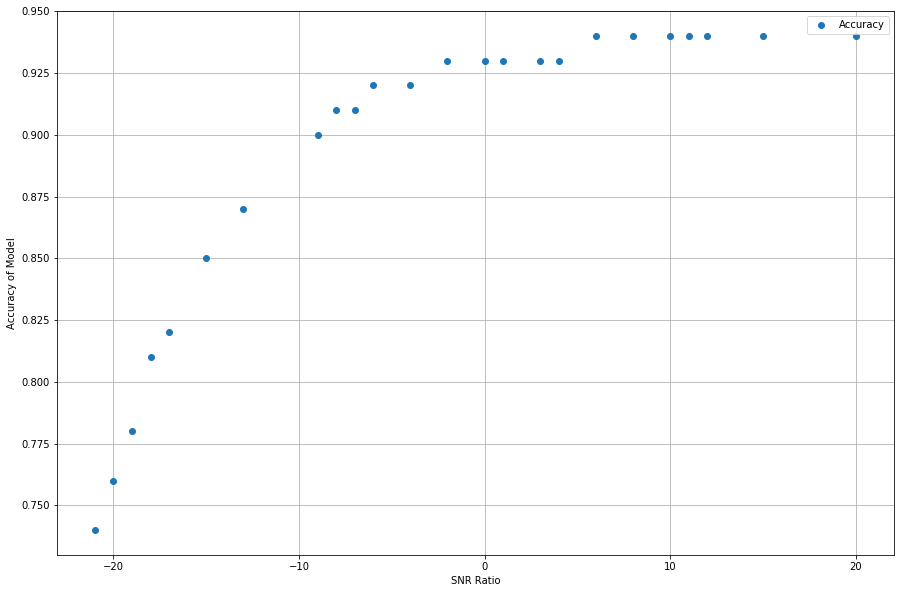

In [38]:
df.plot(x='Noise_Ratio', y='Accuracy', xlabel='SNR Ratio', ylabel='Accuracy of Model', style='o', grid=True, figsize=(15,10))